In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint as odeint_torch
from generate_data import generate_data
from tqdm import tqdm
from functorch import make_functional
from utils import  extract_and_reset_grads
import time

In [2]:
# NN correction
class ClosureTerm(torch.nn.Module):
    def __init__(self, params):
        super(ClosureTerm, self).__init__()
        # params of the neural correction to the dynamical model (FCN model)
        self.trans_layers = params['transition_layers']
        self.transLayers = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend(
            [torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in
             range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_state'])   
    
    def forward(self, x):
        for i in range(self.trans_layers):
            x = torch.tanh(self.transLayers[i](x))
        x = self.out_transLayers(x)
        return x

In [57]:
# "hybrid model"
class HybridMdl(torch.nn.Module):
    def __init__(self, params):
        super(HybridMdl, self).__init__()
        # dimensions :
        self.dim_state = params['dim_state']
        self.closure = ClosureTerm(params)
        # params of the true L63 system
        self.sigma = (torch.from_numpy(np.array(GD.parameters.sigma)).float())
        self.rho = (torch.from_numpy(np.array(GD.parameters.rho)).float())
        self.beta = (torch.from_numpy(np.array(GD.parameters.beta)).float())
    
    def dyn_net(self, t, inp):
        grad = (torch.zeros((inp.size())).to(inp.device))
        grad[:,0] = self.sigma*(inp[:,1]-inp[:,0]);
        grad[:,1] = inp[:,0]*(self.rho-inp[:,2])-inp[:,1];
        grad[:,2] = inp[:,0]*inp[:,1] #+  self.beta*inp[:,2];
        return grad + self.closure(inp)

    def model_dt(self, inp, dt, t0=0,
                grad_mode='EGA-static'):  # flow of the ODE, assuming the flow is autonomous so t0 is always 0
        if grad_mode == 'exact':
            pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt), method='rk4')
            return pred[-1, :, :]
        elif grad_mode == 'EGA-static' or grad_mode == 'EGA-ST' or grad_mode == 'EGA-J':
            with torch.no_grad():
                # blackbox non diff solver, here an adaptive dopri solver
                pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt), method='rk4')
            # computational graph of the blackbox solver
            if grad_mode == 'EGA-static':
                output_p = dt * self.closure(inp.detach()) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-ST':
                output_p = dt * self.closure(inp) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-J':
                output_p = dt * self.dyn_net(t0+dt,inp) + inp
                output_p.data = pred.data[-1, :, :]                
            return output_p
    def forward(self, dt, n, x0, grad_mode='EGA'):
        pred = [x0]
        for i in range(n):
            pred.append(self.model_dt(pred[-1], dt, grad_mode=grad_mode))
        pred_seq = torch.stack(pred)[:, :, :]
        return pred_seq

In [58]:
convergence_diag = {'time_steps': [0.0001, 0.0005, 0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1], 'error_EGA_ST': [], 'error_EGA_Static': [], 'error_EGA_J_Euler': [], 'time_comp_graph': [], 'time_EGA_static': [], 'time_EGA_J_Euler': [], 'time_EGA_ST': []}

In [64]:
convergence_diag = {'n_steps': [1,5,10,15,20,25,30,35,40,45,50,55,60,65,70, 75, 80, 85, 90, 95, 100, 200, 300, 400],'time_steps': [0.01],'error_EGA_ST': [], 'error_EGA_Static': [], 'error_EGA_J_Euler': [], 'norm_error_EGA_ST': [], 'norm_error_EGA_Static': [], 'norm_error_EGA_J_Euler': [], 'time_comp_graph': [], 'time_EGA_static': [], 'time_EGA_J_Euler': [], 'time_EGA_ST': []}


In [65]:
# Generate Lorenz 63 simulations
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = convergence_diag['time_steps'][0]
    nb_loop_data = 60.0

# run the data generation
dataset = generate_data(GD)

In [66]:
for i in tqdm(range(len(convergence_diag['n_steps']))):
    params = {'dt_integration': convergence_diag['time_steps'][0], 'dim_state': 3, 'dim_output': 3, 'transition_layers': 2,
              'dim_hidden_dyn_mdl': 3, 'device': 'cpu', 'Batch_size': 128, 
              'seed': 0, 'n_steps': convergence_diag['n_steps'][i]}
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    
    # make sure we use the same number of initial conditions per time resolution
    rat_data = int(convergence_diag['time_steps'][-1]/params['dt_integration'])
    subsampling = int(params['dt_integration']/convergence_diag['time_steps'][0])
    X_train = torch.from_numpy(dataset[::subsampling][::rat_data]).float()
    train_loader = torch.utils.data.DataLoader(X_train, batch_size=params['Batch_size'], shuffle=False, pin_memory=False, drop_last=True)
    
    # hybrid model
    hybrid_model = HybridMdl(params)

    # EGA static
    time_batch_ega_static, grads_EGA_Static = [], []
    time_batch_ega_J_euler, grads_EGA_J_Euler = [], []
    time_batch_ega_ST, grads_EGA_ST = [], []
    time_batch_comp_G, grads_GT = [], []
    
    for x_data in train_loader:
        x_data = x_data.to(params['device'])
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-static')
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_static = time.time()
        error1.backward()
        end_time_ega_static = time.time()
        time_batch_ega_static.append(end_time_ega_static - start_time_ega_static)
        # params and gradients of EGA static
        grads_EGA_Static.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())

        # EGA Jacobian Euler
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-J')
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_J_euler = time.time()
        error1.backward()
        end_time_ega_J_euler = time.time()
        time_batch_ega_J_euler.append(end_time_ega_J_euler - start_time_ega_J_euler)
        # params and gradients of EGA jacobian (assuming Euler jacobians)
        grads_EGA_J_Euler.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())

        # EGA straight through (keep the jacobian term of the NN model)
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='EGA-ST')
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_ST = time.time()
        error1.backward()
        end_time_ega_ST = time.time()
        time_batch_ega_ST.append(end_time_ega_ST - start_time_ega_ST)
        # params and gradients of EGA straight through 
        grads_EGA_ST.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())

        # Exact gradient of the solver
        pred_mdl = hybrid_model(params['dt_integration'], params['n_steps'], x_data, grad_mode='exact')
        error1 = torch.mean((pred_mdl - torch.zeros_like(pred_mdl)) ** 2)
        start_time_ega_comp_G = time.time()
        error1.backward()
        end_time_ega_comp_G = time.time()
        time_batch_comp_G.append(end_time_ega_comp_G - start_time_ega_comp_G)
        # params and gradients of Exact gradient 
        grads_GT.append(extract_and_reset_grads(hybrid_model).detach().cpu().numpy())
    
    # compute gradient errors
    convergence_diag['error_EGA_ST'].append(np.array(grads_GT) - np.array(grads_EGA_ST)) 
    convergence_diag['error_EGA_Static'].append(np.array(grads_GT) - np.array(grads_EGA_Static)) 
    convergence_diag['error_EGA_J_Euler'].append(np.array(grads_GT) - np.array(grads_EGA_J_Euler)) 
    
    norm_grad = np.abs(np.array(grads_GT))
    norm_grad[np.where(np.abs(np.array(grads_GT))<1E-3)] = 1E-3
    convergence_diag['norm_error_EGA_ST'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_ST))/norm_grad) 
    convergence_diag['norm_error_EGA_Static'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_Static))/norm_grad) 
    convergence_diag['norm_error_EGA_J_Euler'].append(np.abs(np.array(grads_GT) - np.array(grads_EGA_J_Euler))/norm_grad) 
    
    convergence_diag['time_comp_graph'].append(np.array(time_batch_comp_G)) 
    convergence_diag['time_EGA_static'].append(np.array(time_batch_ega_static)) 
    convergence_diag['time_EGA_J_Euler'].append(np.array(time_batch_ega_J_euler)) 
    convergence_diag['time_EGA_ST'].append(np.array(time_batch_ega_ST)) 

100%|██████████| 24/24 [14:19<00:00, 35.83s/it] 


In [56]:
len(convergence_diag['n_steps'])

21

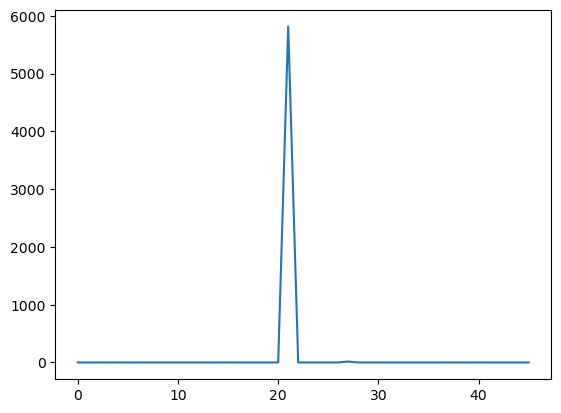

In [42]:
plt.plot(np.array(convergence_diag['norm_error_EGA_J_Euler'])[16,:,29])

In [54]:
np.array(convergence_diag['error_EGA_J_Euler']).shape

(63, 46, 36)

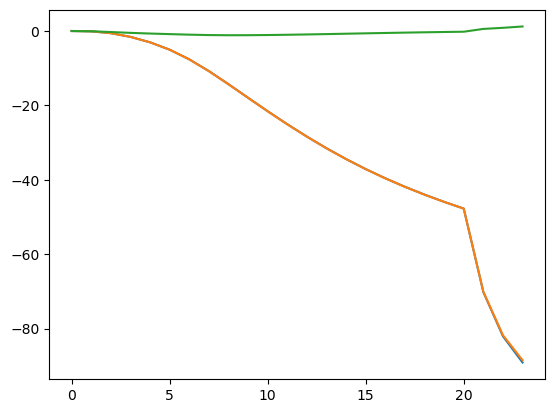

In [67]:
plt.plot( np.nanmean(np.nanmean(np.array(convergence_diag['error_EGA_ST']), axis = -1), axis = -1)*100)
plt.plot(np.nanmean(np.nanmean(np.array(convergence_diag['error_EGA_Static']), axis = -1), axis = -1)*100)
plt.plot(np.nanmean(np.nanmean(np.array(convergence_diag['error_EGA_J_Euler']), axis = -1), axis = -1)*100)

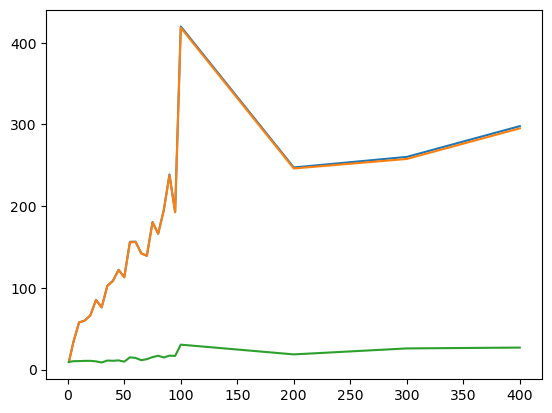

In [71]:
plt.plot(convergence_diag['n_steps'], np.nanmean(np.nanmean(np.array(convergence_diag['norm_error_EGA_ST']), axis = -1), axis = -1)*100)
plt.plot(convergence_diag['n_steps'], np.nanmean(np.nanmean(np.array(convergence_diag['norm_error_EGA_Static']), axis = -1), axis = -1)*100)
plt.plot(convergence_diag['n_steps'], np.nanmean(np.nanmean(np.array(convergence_diag['norm_error_EGA_J_Euler']), axis = -1), axis = -1)*100)


In [20]:
np.nanmean(np.nanmean(np.array(convergence_diag['norm_error_EGA_ST']), axis = -1), axis = -1)

array([0.23565017, 0.47603235, 0.63283455, 0.69010466, 1.421096  ,
       2.352341  , 0.85960454, 1.1861986 , 1.2672542 , 1.3528727 ,
       1.4036256 , 1.7545083 , 1.7605393 , 1.7077492 , 1.6513158 ,
       2.0453548 , 3.5653875 , 2.231755  , 2.7908027 , 2.2703571 ,
       5.961166  ], dtype=float32)

In [19]:
np.array(convergence_diag['norm_error_EGA_ST']).shape

(21, 46, 36)

In [ ]:
np.linalg.norm(np.array(grads_GT) - np.array(grads_EGA_ST), axis = -1)/np.linalg.norm(np.array(grads_GT), axis = -1)

In [ ]:
np.array(convergence_diag['error_EGA_Static']).shape

In [ ]:
plt.plot((np.array(convergence_diag['norm_error_EGA_J_Euler']).mean(axis = -1)))
plt.plot((np.array(convergence_diag['norm_error_EGA_Static']).mean(axis = -1)))


In [ ]:
plt.plot(np.abs(np.array(convergence_diag['error_EGA_Static'])).mean(axis = -1).mean(axis = -1))
plt.plot(np.abs(np.array(convergence_diag['error_EGA_J_Euler'])).mean(axis = -1).mean(axis = -1))


In [ ]:
np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_EGA_static']).mean(axis = -1)

In [ ]:
plt.semilogx(np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_comp_graph']).mean(axis = -1))
plt.semilogx(np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_EGA_J_Euler']).mean(axis = -1))
plt.semilogx(np.array(convergence_diag['time_comp_graph']).mean(axis = -1)/np.array(convergence_diag['time_EGA_static']).mean(axis = -1))

In [ ]:
np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_J_Euler'])

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_ST']), lw = 5, label = 'ST-EGA')
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_J_Euler']), lw = 5, label = 'J-Euler-EGA')
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_EGA_static']), lw = 5, label = 'Static-EGA')
plt.plot(convergence_diag['n_steps'],np.array(convergence_diag['time_comp_graph'])/np.array(convergence_diag['time_comp_graph']), lw = 5, label = 'Computational graph')
plt.legend()

In [ ]:
convergence_diag['time_EGA_ST']

In [ ]:
plt.figure(figsize=(10,10))
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_ST'])).mean(axis = -1),'*', markersize = 15, lw = 5, label = 'ST-EGA')
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_Static'])).mean(axis = -1), lw = 5, label = 'Static-EGA')
plt.loglog(convergence_diag['time_steps'],torch.abs(torch.stack(convergence_diag['error_EGA_J_Euler'])).mean(axis = -1), lw = 5, label = 'J-Euler-EGA')
plt.loglog(convergence_diag['time_steps'],50000*np.array(convergence_diag['time_steps'])**2, label = 'Second order', lw = 5)
plt.tick_params(axis='both')
plt.grid()
plt.legend()
plt.xlabel('h')
plt.ylabel('Gradient error')
plt.show()